<a href="https://colab.research.google.com/github/tetsuroba/HiraganaDNN/blob/master/HiraganaDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importok


In [0]:
!pip install bitstring
from google.colab import drive
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
from PIL import ImageOps, ImageMath
from matplotlib import pyplot as plt
import cv2
import pylab
import struct
import bitstring
from PIL import Image
import tensorflow as tf
import sys
import codecs
from google.colab import files


#Adatbázis importálása


In [0]:
drive.mount('/content/gdrive')

filename = "/content/gdrive/My Drive/ETL4/ETL4C"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#Alap változók

In [0]:
hiragana_chars = "をゐゑあいうえおかきくけこさしすせそたちつてとなにぬねのはひふへほまみむめもやゆよらりるれろわん"
latin = "wo,wi,we,a,i,u,e,o,ka,ki,ku,ke,ko,sa,shi,su,se,so,ta,chi,tsu,te,to,na,ni,nu,ne,no,ha,hi,fu,he,ho,ma,mi,mu,me,mo,ya,yu,yo,ra,ri,ru,re,ro,wa,n";



def read_input(f, pos=2):
   f = bitstring.ConstBitStream(filename=f)
   f.bytepos = pos * 2952
   r = f.readlist('2*uint:36,uint:8,pad:28,uint:8,pad:28,4*uint:6,pad:12,15*uint:36,pad:1008,bytes:21888')
   return r

def create_data():
    data =  np.zeros((6113,76,72)) #5472
    labels = np.zeros(6113)
    for i in range(6113):
        r = read_input(filename,pos=i)
        iF = Image.frombytes('F', (r[18], r[19]), r[-1], 'bit', 4)
        iP = iF.convert('L')
        enhancer = ImageEnhance.Brightness(iP)
        iE = enhancer.enhance(r[20])
        temp=np.array(iE)
        data[i,:,:] = temp
        labels[i] = r[2]
    return (data,labels)

def preprocessing_data(data1):
    kernel = np.ones((3,3),np.float32)/9
    crop_temp = np.zeros((data.shape[0],data1.shape[2],data1.shape[2]))
    for i in range(data1.shape[0]):
          dst = cv2.GaussianBlur(data1[i,:,:],(3,3),0)
          ret,data1[i,:,:] = cv2.threshold(dst,0,255,cv2.THRESH_TOZERO+cv2.THRESH_OTSU)
          crop_temp[i,:,:] = data1[i,:72,:]
    return crop_temp

#Képnormalizálás

In [0]:
r = read_input(filename)
(data,labels) = create_data()
data = np.array(data, dtype = np.uint8) 

data1=data.copy()
data1 = preprocessing_data(data1)

#data1 labels



In [0]:
#print(data[1].shape)

(76, 72)


In [0]:
for i in range(len(labels)):
  if(int(labels[i]) == 166):
    labels[i] = 0
  elif(int(labels[i]) == 168):
    labels[i] = 1
  elif(int(labels[i]) == 170):
    labels[i] = 2
  else:
    labels[i] = labels[i] - 174

あ


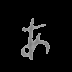

い


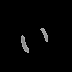

う


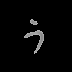

え


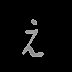

お


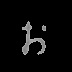

In [0]:
for i in range(5):
  img = Image.fromarray(np.uint8(data1[i] * 255) , 'L')
  print(hiragana_chars[int(labels[i])])
  display(img)


In [0]:
print(data1.shape)

(6113, 72, 72)


#Adatfeldolgozás


In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

data1 = data1/160

dataset_size = len(data1)
#data1 = data1.reshape(dataset_size,-1)

c_features, data_labels_encoded = unison_shuffled_copies(data1, labels)

In [0]:
data_labels_encoded_ohe = np.reshape(data_labels_encoded,(-1,1))

ohe_enc = OneHotEncoder()
ohe_enc.fit(data_labels_encoded_ohe)
data_labels_encoded_ohe = ohe_enc.transform(data_labels_encoded_ohe).toarray()

# Osztályok száma
num_classes = data_labels_encoded_ohe.shape[1]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
#print(data_labels_encoded)

[29.  0. 23. ...  6. 15. 30.]


In [0]:
distrib = {}


for i in range(len(labels)):
  try:
    distrib[int(labels[i])] += 1
  except:
    distrib[int(labels[i])] = 1

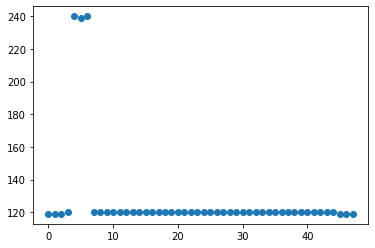

In [0]:
plt.scatter(distrib.keys(),distrib.values(),vmin=0)

In [0]:
# Adatok szétválasztása

tr_data = c_features[:int(c_features.shape[0]*0.8),:]
tr_labels_ohe = data_labels_encoded_ohe[:int(data_labels_encoded_ohe.shape[0]*0.8),:]
tr_labels = data_labels_encoded[:int(data_labels_encoded_ohe.shape[0]*0.8)]

val_data = c_features[int(c_features.shape[0]*0.8):int(c_features.shape[0]*0.9),:]
val_labels_ohe = data_labels_encoded_ohe[int(data_labels_encoded_ohe.shape[0]*0.8):int(data_labels_encoded_ohe.shape[0]*0.9),:]
val_labels = data_labels_encoded[int(data_labels_encoded.shape[0]*0.8):int(data_labels_encoded.shape[0]*0.9)]

test_data = c_features[int(data_labels_encoded_ohe.shape[0]*0.9):,:]
test_labels_ohe = data_labels_encoded_ohe[int(data_labels_encoded_ohe.shape[0]*0.9):,:]
test_labels = data_labels_encoded[int(data_labels_encoded.shape[0]*0.9):]

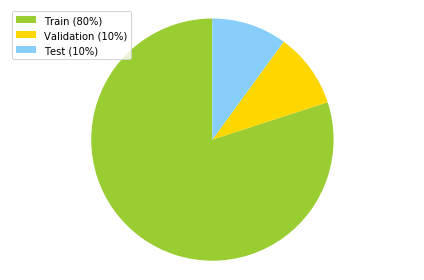

In [0]:
import math
graph_labels = [r'Train (' + str(int(math.ceil(len(tr_data)/len(data1) * 100))) + '%)', r'Validation (' + str(int(math.ceil(len(val_data)/len(data1) * 100))) + '%)', r'Test (' + str(int(math.floor((len(test_data)/len(data1) * 100)))) + '%)']
sizes = [len(tr_data)/len(data1)*100,len(val_data)/len(data1)*100,len(test_data)/len(data1)*100]
colors = ['yellowgreen', 'gold', 'lightskyblue']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, graph_labels, loc="best")

plt.axis('equal')
plt.tight_layout()
plt.show()


#Hagyományos SVM háló


In [0]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
#clf = svm.SVC(gamma=0.1, C=10)

parameters = {'kernel':('linear', 'rbf'), 'C':(0.1, 1, 10)}
clf = GridSearchCV(svm.SVC(degree=4), parameters)
#clf = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    #decision_function_shape='ovr', degree=4, gamma='auto_deprecated',
    #kernel='linear', max_iter=-1, probability=False, random_state=None,
    #shrinking=True, tol=0.001, verbose=False) #legjobb model
#clf.fit(x_train, y_train_cat)
#print(clf.best_score_) 
#print(clf.best_params_)
#model = clf.best_estimator_

#print(model)

#train = clf.fit(x_train, y_train_cat)
#train

In [0]:
flattened_tr_data = tr_data.reshape(len(tr_data),-1)
flattened_val_data = val_data.reshape(len(val_data),-1)
flattened_test_data = test_data.reshape(len(test_data),-1)

In [0]:

clf = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False) #legjobb model,
train = clf.fit(flattened_tr_data,tr_labels)
train

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
# Evaluate performance

# Train set
train_pred = clf.predict(flattened_tr_data)
train_pred_scores = train_pred == tr_labels
train_pred_scores = sum(train_pred_scores)
print("Train score: ", (train_pred_scores/flattened_tr_data.shape[0])*100)

# Validation set
val_pred = clf.predict(flattened_val_data)
val_pred_scores = val_pred == val_labels
val_pred_scores = sum(val_pred_scores)
print("Val score: ", (val_pred_scores/flattened_val_data.shape[0])*100)

# Test set
test_pred = clf.predict(flattened_test_data)
test_pred_scores = test_pred == test_labels
test_pred_scores = sum(test_pred_scores)
print("Test score: ", (test_pred_scores/flattened_test_data.shape[0])*100)

Train score:  100.0
Val score:  68.57610474631751
Test score:  68.13725490196079


4.0


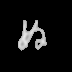

Guess: ゆ Correct: ぬ


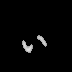

Guess: い Correct: い


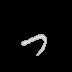

Guess: の Correct: つ


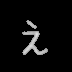

Guess: え Correct: え


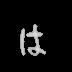

Guess: は Correct: は


In [0]:
print(test_pred[1])
abc = test_data.reshape(len(test_data),72,72)
for i in range(5):
  img = Image.fromarray(np.uint8(abc[i] * 255) , 'L')
  display(img)
  print("Guess: " + hiragana_chars[int(test_pred[i])] + " Correct: " + hiragana_chars[int(test_labels[i])])

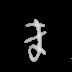

Guess: ま Correct: ま


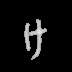

Guess: け Correct: け


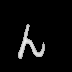

Guess: ん Correct: ん


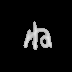

Guess: ぬ Correct: ね


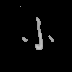

Guess: つ Correct: ふ


In [0]:
abc = val_data.reshape(len(val_data),72,72)
for i in range(5):
  img = Image.fromarray(np.uint8(abc[i] * 255) , 'L')
  display(img)
  print("Guess: " + hiragana_chars[int(val_pred[i])] + " Correct: " + hiragana_chars[int(val_labels[i])])

#TF Mélyháló

In [0]:
learning_rate = 0.2
num_steps = 1000
batch_size = 256
display_step = 100

n_hidden_1 = 512
n_hidden_2 = 512
n_hidden_3 = 256
num_input = 5184
num_classes = 48

In [0]:
print(tr_data.shape)

(4890, 72, 72)


In [0]:
tr_data_flattened = tr_data.reshape(len(tr_data),-1)

In [0]:
print(tr_data_flattened[0].shape)

(5184,)


In [0]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': tr_data_flattened}, y = tr_labels,batch_size = batch_size,num_epochs = None,shuffle=True)

In [0]:
def neural_net(x_dict):
  x = x_dict['images']

  layer_1 = tf.layers.dense(x,n_hidden_1,activation=tf.nn.relu)

  layer_2 = tf.layers.dense(layer_1, n_hidden_2, activation=tf.nn.relu)

  out_layer = tf.layers.dense(layer_2,num_classes)
  return out_layer

In [0]:
def model_fn(features,labels,mode):
  logits = neural_net_dowd(features)

  pred_classes = tf.argmax(logits,axis=1)
  pred_probas = tf.nn.softmax(logits)

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode,predictions=pred_classes)

  loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())

  acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

  estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

  return estim_specs

In [0]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3bsralzo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4c2bd680f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
model.train(input_fn, steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp3bsralzo/model.ckpt.
INFO:tensorflow:loss = 3.8751711379137728, step = 0
INFO:tensorflow:global_step/sec: 90.629
INFO:tensorflow:loss = 1.637103843376413, step = 100 (1.107 sec)
INFO:tensorflow:global_step/sec: 89.8754
INFO:tensorflow:loss = 1.1481204869933923, step = 200 (1.114 sec)
INFO:tensorflow:global_step/sec: 89.427
INFO:tensorflow:loss = 0.4003610129656778, step = 300 (1.117 sec)
INFO:tensorflow:global_step/sec: 89.0353
INFO:tensorflow:loss = 0.18907127829868617, step = 400 (1.121 sec)
INFO:tensorflow:global_step/sec: 91.2381
INFO:tensorflow:loss = 0.18432892883695404, step = 500 (1.097 sec)
INFO:tensorflow:global_step/sec: 91.0435
INFO:tensorflow:loss = 0.03510085090450177, step = 600 (1.100

In [0]:
test_data_flattened = test_data.reshape(len(test_data),-1)
val_data_flattened = val_data.reshape(len(val_data),-1)

In [0]:
run_config = tf.estimator.RunConfig(save_checkpoints_steps=1000)

In [0]:
input_fn_test = tf.estimator.inputs.numpy_input_fn(
    x={'images':test_data_flattened}, y = test_labels,
    batch_size= batch_size,shuffle=False)
input_fn_val = tf.estimator.inputs.numpy_input_fn(
    x={'images':val_data_flattened}, y = val_labels,
    batch_size= batch_size,shuffle=False)

predictions = model.predict(input_fn_val)



In [0]:
incorrect = 0
allData = len(val_data_flattened)
k = 0
for i in predictions:
  if(i != val_labels[k]):
    incorrect += 1
  k+=1
print(((allData-incorrect)/allData) * 100)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp3bsralzo/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
82.16039279869068


In [0]:
dropout = 1.0
def neural_net_do(x_dict):
  x = x_dict['images']

  layer_1 = tf.layers.dense(x,n_hidden_1,activation=tf.nn.relu)
  layer_1 = tf.layers.dropout(layer_1,dropout)
  layer_2 = tf.layers.dense(layer_1, n_hidden_2, activation=tf.nn.relu)
  layer_2 = tf.layers.dropout(layer_2,dropout)
  layer_3 = tf.layers.dense(layer_2,n_hidden_3,activation=tf.nn.relu)
  out_layer = tf.layers.dense(layer_3,num_classes)
  return out_layer

In [0]:
regularizer = tf.contrib.layers.l1_regularizer(0.5)
def neural_net_wd(x_dict):
  x = x_dict['images']

  layer_1 = tf.layers.dense(x,n_hidden_1,activation=tf.nn.relu,kernel_regularizer=regularizer)

  layer_2 = tf.layers.dense(layer_1, n_hidden_2, activation=tf.nn.relu,kernel_regularizer=regularizer)

  out_layer = tf.layers.dense(layer_2,num_classes,kernel_regularizer=regularizer)
  return out_layer

In [0]:
dropout = 0
regularizer = tf.contrib.layers.l1_regularizer(0.5)
def neural_net_dowd(x_dict):
  x = x_dict['images']

  layer_1 = tf.layers.dense(x,n_hidden_1,activation=tf.nn.relu,kernel_regularizer=regularizer)
  layer_1 = tf.layers.dropout(layer_1,dropout)
  layer_2 = tf.layers.dense(layer_1, n_hidden_2, activation=tf.nn.relu,kernel_regularizer=regularizer)
  layer_2 = tf.layers.dropout(layer_2,dropout)
  layer_3 = tf.layers.dense(layer_2,n_hidden_3,activation=tf.nn.relu,kernel_regularizer=regularizer)

  out_layer = tf.layers.dense(layer_3,num_classes,kernel_regularizer=regularizer)
  return out_layer



In [0]:
results = np.zeros((5,5))

In [0]:
model.train(input_fn, steps=num_steps)
result = model.evaluate(input_fn_test)
results[4][4] = result['accuracy']

In [0]:
print(results)
epochs = [1,2,3,4,5]

[[0.34640524 0.40849674 0.46895424 0.501634   0.49346405]
 [0.64705884 0.68954247 0.67483658 0.66666669 0.68464053]
 [0.72875816 0.73039216 0.73692811 0.751634   0.75980395]
 [0.79738563 0.82026142 0.80228758 0.79575163 0.80228758]
 [0.80228758 0.80718952 0.80228758 0.80228758 0.80555558]]


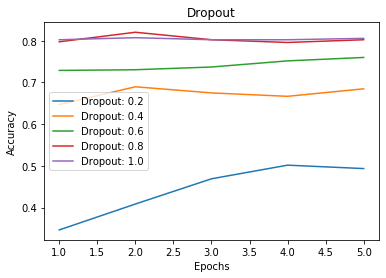

In [0]:
for i in range(5):
  plt.plot(epochs,results[i], label = "Dropout: " + str((i * 2 + 2)/10))

plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.title('Dropout') 
plt.legend() 
plt.show() 

#Konvulúciós háló


In [0]:
import keras

Using TensorFlow backend.


In [0]:
tr_data_conv = np.expand_dims(tr_data,axis=3) #28,28,1
val_data_conv = np.expand_dims(val_data,axis=3)
test_data_conv = np.expand_dims(test_data,axis=3)

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout
from keras import regularizers
from keras.callbacks import ModelCheckpoint


def create_model():
  num_filters = 64
  filter_size = 6
  pool_size = 3
  model = Sequential()
  model.add(Conv2D(num_filters,
          filter_size,
          input_shape=(72, 72, 1),
          strides=1,
          padding='same',
          activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Conv2D(num_filters,
          filter_size,
          input_shape=(36, 36, 1),
          strides=1,
          padding='same',
          activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(MaxPooling2D(pool_size=pool_size,padding='valid'))
  model.add(Dropout(0.4))
  model.add(Dense(32, activation='relu'))
  model.add(Conv2D(num_filters,
          filter_size,
          input_shape=(17, 17, 1),
          strides=1,
          padding='same',
          activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(48, activation='softmax'))

  
  return model

def train_model():
  model = create_model()

  filepath="weights-improvement-{epoch:02d}-{val_acc:02d}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]
  model.compile(
    'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )

  metrics  = model.fit(
    tr_data_conv,
    tr_labels_ohe,
    epochs=20,
    validation_data=(test_data_conv,test_labels_ohe),
    callbacks=callbacks_list
  )


In [0]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 72, 72, 64)        2368      
_________________________________________________________________
dense_91 (Dense)             (None, 72, 72, 128)       8320      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 72, 72, 64)        294976    
_________________________________________________________________
dense_92 (Dense)             (None, 72, 72, 64)        4160      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
dense_93 (Dense)             (None, 24, 24, 32)      

In [0]:
model.load_weights('/content/weights-improvement-15-val_acc91.hdf5')

In [0]:
predictions = model.predict(test_data_conv)
incorrect = 0
for i in range(len(predictions)):
  if(np.argmax(predictions[i]) != np.argmax(test_labels_ohe[i])):
    incorrect += 1
print("Accuracy: " + str( (round((len(predictions)-incorrect) / len(predictions)*100,2) )) + "%")

Accuracy: 91.01%


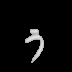

Guess: ろCorrect: う


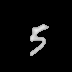

Guess: らCorrect: ち


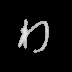

Guess: ねCorrect: わ


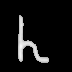

Guess: にCorrect: ん


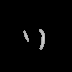

Guess: りCorrect: い


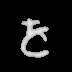

Guess: きCorrect: を


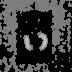

Guess: しCorrect: い


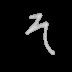

Guess: てCorrect: そ


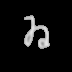

Guess: ねCorrect: ゐ


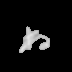

Guess: ぬCorrect: ね


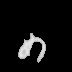

Guess: のCorrect: め


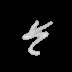

Guess: きCorrect: そ


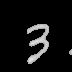

Guess: うCorrect: ろ


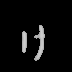

Guess: りCorrect: け


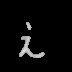

Guess: とCorrect: え


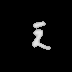

Guess: まCorrect: え


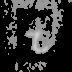

Guess: ほCorrect: て


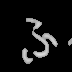

Guess: るCorrect: ふ


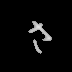

Guess: へCorrect: さ


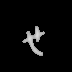

Guess: やCorrect: せ


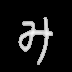

Guess: けCorrect: み


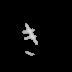

Guess: さCorrect: き


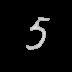

Guess: うCorrect: ら


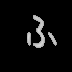

Guess: かCorrect: ふ


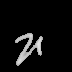

Guess: みCorrect: ひ


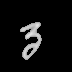

Guess: まCorrect: る


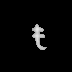

Guess: そCorrect: も


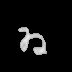

Guess: ねCorrect: ゐ


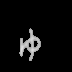

Guess: わCorrect: ゆ


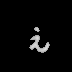

Guess: んCorrect: え


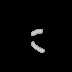

Guess: てCorrect: こ


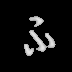

Guess: ゐCorrect: ふ


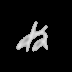

Guess: あCorrect: ぬ


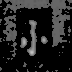

Guess: らCorrect: ふ


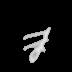

Guess: なCorrect: ま


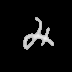

Guess: ふCorrect: み


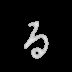

Guess: ゐCorrect: る


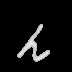

Guess: えCorrect: ん


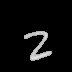

Guess: つCorrect: て


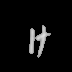

Guess: みCorrect: け


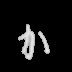

Guess: れCorrect: か


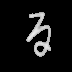

Guess: ゐCorrect: る


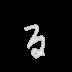

Guess: るCorrect: ゐ


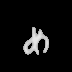

Guess: あCorrect: め


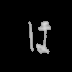

Guess: はCorrect: ほ


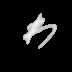

Guess: もCorrect: わ


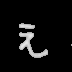

Guess: むCorrect: え


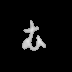

Guess: あCorrect: む


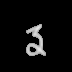

Guess: まCorrect: る


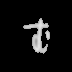

Guess: すCorrect: む


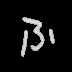

Guess: かCorrect: ふ


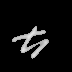

Guess: おCorrect: ち


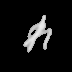

Guess: くCorrect: れ


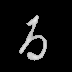

Guess: ろCorrect: る


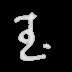

Guess: をCorrect: む


In [0]:
for i in range(len(predictions)):
  if(np.argmax(predictions[i]) != np.argmax(test_labels_ohe[i])):
    abc = test_data.reshape(len(test_data),72,72)
    img = Image.fromarray(np.uint8(abc[i] * 255) , 'L')
    display(img)
    print("Guess: " +  hiragana_chars[int(np.argmax(predictions[i]))] + "Correct: " + hiragana_chars[int(np.argmax(test_labels_ohe[i]))])

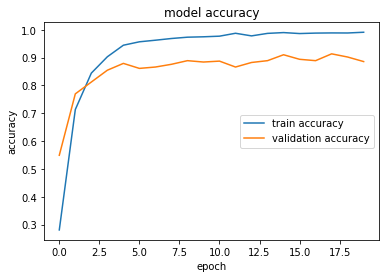

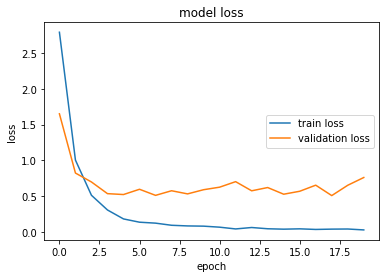

In [0]:
plt.plot(metrics.history['acc'])
plt.plot(metrics.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='center right')
plt.show()
plt.plot(metrics.history['loss'])
plt.plot(metrics.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='center right')
plt.show()

In [0]:
#Save model
model.save("bestResult.h5")
